In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,root_mean_squared_error



In [123]:
X_train_1 = pd.read_csv("../data/boost/X_train_boost_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/boost/X_train_boost_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/boost/X_train_boost_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")
X_test =pd.read_csv("../data/boost/X_test_boost.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

# 1. CatBoost

## 1.1 Modelling

reference source:
https://www.datacamp.com/tutorial/catboost?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157156375191&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=720362650048&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=9062544&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-bfcm24&gad_source=1&gbraid=0AAAAADQ9WsG32eomnlc7yr8qhNh_B0rIf&gclid=Cj0KCQiAouG5BhDBARIsAOc08RTtF6F_VSv0Hck1Glr8j0gGVjz_VMrRDLXIkIP5HY1nmm-GCR6qguUaAmvBEALw_wcB

In [124]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]



In [125]:
categorical_feature_indices 


[0, 1, 2, 3, 4, 5, 7, 13]

In [126]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train, cat_features=categorical_feature_indices)  

## 1.2 Evaluation

In [127]:
#Make predictions
y_pred = model.predict(X_test)

# Evaluate using mean squared error (MSE)
mse = root_mean_squared_error(y_test, y_pred)


test_r2 = r2_score(y_test, y_pred)


print(f"Test RMSE: {mse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 30647.69027868796
Test R2 Score: 0.9687033057355025


In [ ]:
# Make predictions on the train set
y_train_pred = model.predict(X_train)

# Calculate train performance metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2 Score: {train_r2}")

Test RMSE: 30189.43254688699
Test R2 Score: 0.969504429945646


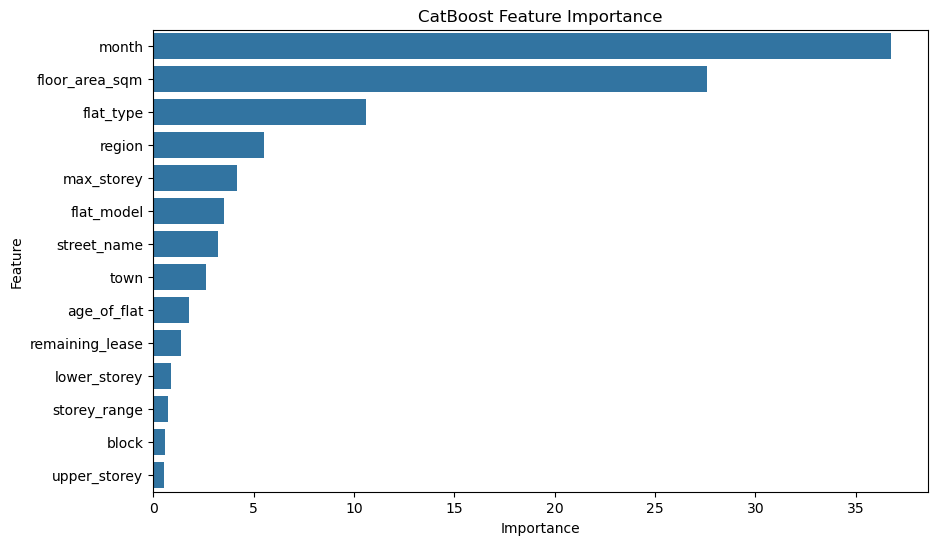

In [130]:
# Extract feature importances from the CatBoost model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importances.head(20))
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 1.3 Refining

# 2. LightGBM

## 2.1 Modelling

https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [131]:
regressor = lgb.LGBMRegressor()


In [132]:
# Identify categorical columns by their data type
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_columns)


Categorical columns: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'region']


In [133]:
# Identify categorical columns
categorical_columns = ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model','region']

# Convert these columns to 'category' type
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')


https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

In [134]:
import lightgbm as lgb

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 50,
    "max_depth": -1,
    "learning_rate": 0.01,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 5,
    "min_data_in_leaf": 20,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    "num_iterations": 1000,
    "verbose": 0,

}

# Prepare the dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Training the model with early stopping
gbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predicting with the model
y_pred = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 18027.8	valid_0's l2: 7.59702e+08


## 2.2 Evaluation

In [136]:

# Evaluate using mean squared error (MSE)
mse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)


print(f"Test RMSE: {mse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 27562.688682020784
Test R2 Score: 0.9746868538407625


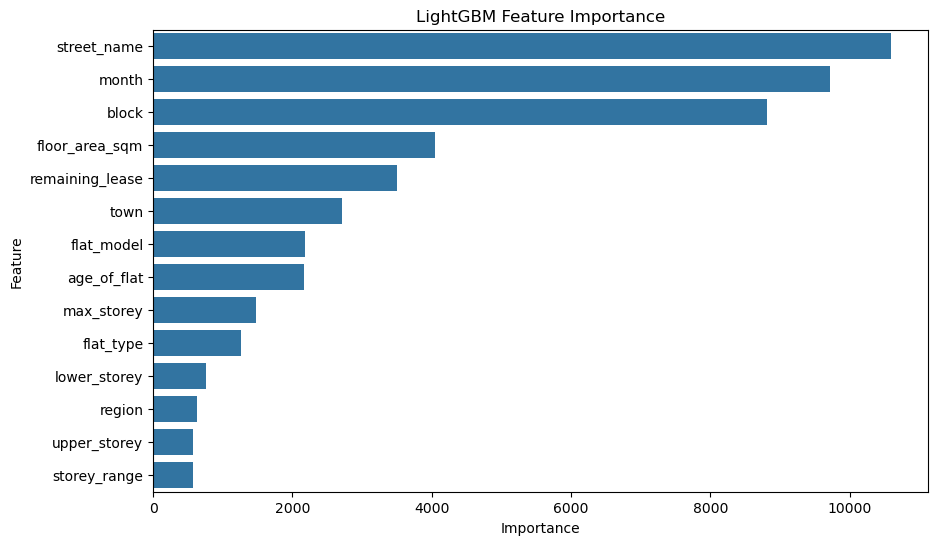

In [137]:
# Getting feature importances from the LightGBM model
feature_importance_values = gbm_model.feature_importance(importance_type='split')
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_values
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importances.head(20))
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### 